In [1]:
import pickle, random, os
import numpy as np
#import skimage.data as imd
import matplotlib.pyplot as plt
#import tensorflow.compat.v1 as tf
import tensorflow as tf
#tf.disable_v2_behavior() 
from tensorflow.python.framework import ops
#from skimage import transform
#from skimage.color import rgb2gray

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
ops.reset_default_graph()
sess = tf.Session()

## Cogemos los datos

In [3]:
infile = open('../data/data8.pickle','rb')
new_dict = pickle.load(infile)
y_train = new_dict['y_train']
x_train = new_dict['x_train'][:,0,:,:]
y_test = new_dict['y_test']
x_test = new_dict['x_test'][:,0,:,:]

In [4]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = x_train[0].shape[0]
image_height = x_train[0].shape[1]
target_size = max(y_train)+1
num_chanels = 1
generations = 2500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
full_connected_size1 = 120

In [5]:
x_input_shape = (batch_size, image_width, image_height, num_chanels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (None, image_width, image_height, num_chanels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.float32, shape = (evaluation_size))

In [6]:
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_chanels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
                    
conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
resulting_width = image_width // (max_pool_size1*max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)

full1_input_size = resulting_width*resulting_height*conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, full_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype = tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([full_connected_size1, full_connected_size1], stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype=tf.float32))

full3_weight = tf.Variable(tf.truncated_normal([full_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
full3_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

In [8]:
def my_advanced_conv_neural_net(input_data):
    # First Layer: Conv+ReLU+Maxpool+BatchNormalization
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1,1,1,1], padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1, max_pool_size1,1], 
                               strides=[1, max_pool_size1, max_pool_size1,1], padding="SAME")
    norm_1 = tf.nn.lrn(max_pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)
    # Second layer: Conv+ReLU+Maxpool+BatchNormalization
    conv2 = tf.nn.conv2d(norm_1, conv2_weight, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size2, max_pool_size2,1], 
                               strides=[1, max_pool_size2, max_pool_size2,1], padding="SAME")
    norm_2 = tf.nn.lrn(max_pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)
    # Flattening
    flat_output = tf.contrib.layers.flatten(norm_2)
    # Third layer: Fully connected
    fully_connected_1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    fully_connected_1 = tf.nn.dropout(fully_connected_1, 0.87)
    # Fourth layer: Fully connected
    fully_connected_2 = tf.nn.relu(tf.add(tf.matmul(fully_connected_1, full2_weight), full2_bias))
    fully_connected_2 = tf.nn.dropout(fully_connected_2, 0.87)
    # Fith layer: Fully connected
    fully_connected_3 = tf.add(tf.matmul(fully_connected_2, full3_weight), full3_bias)
    return fully_connected_3

In [9]:
model_ouput = my_advanced_conv_neural_net(x_input)
test_model_output = my_advanced_conv_neural_net(eval_input)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_ouput, labels = y_target))

In [11]:
prediction = tf.nn.softmax(model_ouput)
test_prediction = tf.nn.softmax(test_model_output)

In [12]:
my_optim = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
train_step = my_optim.minimize(loss)

In [13]:
init = tf.global_variables_initializer()
sess.run(init)

In [14]:
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis = 1)
    num_corrects = np.sum(np.equal(batch_predictions, targets))
    return 100.0*num_corrects/batch_predictions.shape[0]

In [15]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []
for i in range(generations):
    rand_idx = np.random.choice(len(x_train), size = batch_size)
    rand_x = x_train[rand_idx]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = y_train[rand_idx]
    train_dict = {x_input:rand_x, y_target:rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    if(i+1) % eval_every == 0:
        rand_idx_eval = np.random.choice(len(x_test), size = evaluation_size)
        rand_x_eval = x_test[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)
        rand_y_eval = y_test[rand_idx_eval]
        test_dict = {eval_input:rand_x_eval, eval_target:rand_y_eval}
        temp_test_preds = sess.run( test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        i_vals.append(i+1)
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
 
        acc_and_loss = [(i+1),temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Iteration {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))

Iteration 5. Train Loss: 3.855. Train Acc: 2.000. Test Acc: 3.200
Iteration 10. Train Loss: 3.811. Train Acc: 1.000. Test Acc: 4.200
Iteration 15. Train Loss: 3.728. Train Acc: 2.000. Test Acc: 4.400
Iteration 20. Train Loss: 3.752. Train Acc: 2.000. Test Acc: 5.600
Iteration 25. Train Loss: 3.738. Train Acc: 5.000. Test Acc: 5.200
Iteration 30. Train Loss: 3.703. Train Acc: 5.000. Test Acc: 6.600
Iteration 35. Train Loss: 3.696. Train Acc: 7.000. Test Acc: 7.600
Iteration 40. Train Loss: 3.717. Train Acc: 2.000. Test Acc: 7.200
Iteration 45. Train Loss: 3.664. Train Acc: 8.000. Test Acc: 7.400
Iteration 50. Train Loss: 3.671. Train Acc: 3.000. Test Acc: 6.000
Iteration 55. Train Loss: 3.678. Train Acc: 5.000. Test Acc: 5.600
Iteration 60. Train Loss: 3.672. Train Acc: 6.000. Test Acc: 6.000
Iteration 65. Train Loss: 3.645. Train Acc: 7.000. Test Acc: 6.200
Iteration 70. Train Loss: 3.678. Train Acc: 3.000. Test Acc: 7.000
Iteration 75. Train Loss: 3.699. Train Acc: 6.000. Test Acc: 8.

Iteration 595. Train Loss: 0.991. Train Acc: 69.000. Test Acc: 61.600
Iteration 600. Train Loss: 0.911. Train Acc: 71.000. Test Acc: 68.600
Iteration 605. Train Loss: 1.110. Train Acc: 63.000. Test Acc: 69.800
Iteration 610. Train Loss: 1.108. Train Acc: 70.000. Test Acc: 68.600
Iteration 615. Train Loss: 0.945. Train Acc: 73.000. Test Acc: 63.600
Iteration 620. Train Loss: 1.016. Train Acc: 73.000. Test Acc: 66.600
Iteration 625. Train Loss: 1.084. Train Acc: 66.000. Test Acc: 69.400
Iteration 630. Train Loss: 0.714. Train Acc: 81.000. Test Acc: 67.400
Iteration 635. Train Loss: 0.769. Train Acc: 80.000. Test Acc: 67.000
Iteration 640. Train Loss: 1.198. Train Acc: 71.000. Test Acc: 67.000
Iteration 645. Train Loss: 0.698. Train Acc: 84.000. Test Acc: 69.800
Iteration 650. Train Loss: 0.991. Train Acc: 67.000. Test Acc: 68.400
Iteration 655. Train Loss: 0.883. Train Acc: 71.000. Test Acc: 65.800
Iteration 660. Train Loss: 0.844. Train Acc: 80.000. Test Acc: 67.000
Iteration 665. Train

Iteration 1180. Train Loss: 0.259. Train Acc: 95.000. Test Acc: 78.000
Iteration 1185. Train Loss: 0.481. Train Acc: 79.000. Test Acc: 79.000
Iteration 1190. Train Loss: 0.413. Train Acc: 87.000. Test Acc: 79.200
Iteration 1195. Train Loss: 0.672. Train Acc: 83.000. Test Acc: 81.800
Iteration 1200. Train Loss: 0.426. Train Acc: 89.000. Test Acc: 79.400
Iteration 1205. Train Loss: 0.422. Train Acc: 85.000. Test Acc: 80.400
Iteration 1210. Train Loss: 0.323. Train Acc: 89.000. Test Acc: 81.600
Iteration 1215. Train Loss: 0.463. Train Acc: 86.000. Test Acc: 76.000
Iteration 1220. Train Loss: 0.498. Train Acc: 84.000. Test Acc: 81.400
Iteration 1225. Train Loss: 0.537. Train Acc: 85.000. Test Acc: 83.400
Iteration 1230. Train Loss: 0.393. Train Acc: 90.000. Test Acc: 81.200
Iteration 1235. Train Loss: 0.445. Train Acc: 89.000. Test Acc: 80.200
Iteration 1240. Train Loss: 0.481. Train Acc: 87.000. Test Acc: 78.400
Iteration 1245. Train Loss: 0.401. Train Acc: 85.000. Test Acc: 82.400
Iterat

Iteration 1760. Train Loss: 0.298. Train Acc: 89.000. Test Acc: 84.000
Iteration 1765. Train Loss: 0.462. Train Acc: 86.000. Test Acc: 83.200
Iteration 1770. Train Loss: 0.276. Train Acc: 91.000. Test Acc: 86.000
Iteration 1775. Train Loss: 0.287. Train Acc: 89.000. Test Acc: 84.800
Iteration 1780. Train Loss: 0.303. Train Acc: 91.000. Test Acc: 80.800
Iteration 1785. Train Loss: 0.377. Train Acc: 89.000. Test Acc: 79.000
Iteration 1790. Train Loss: 0.304. Train Acc: 90.000. Test Acc: 83.800
Iteration 1795. Train Loss: 0.224. Train Acc: 93.000. Test Acc: 82.800
Iteration 1800. Train Loss: 0.271. Train Acc: 91.000. Test Acc: 83.200
Iteration 1805. Train Loss: 0.296. Train Acc: 89.000. Test Acc: 85.200
Iteration 1810. Train Loss: 0.257. Train Acc: 94.000. Test Acc: 82.400
Iteration 1815. Train Loss: 0.221. Train Acc: 93.000. Test Acc: 83.400
Iteration 1820. Train Loss: 0.196. Train Acc: 95.000. Test Acc: 82.400
Iteration 1825. Train Loss: 0.435. Train Acc: 84.000. Test Acc: 84.600
Iterat

Iteration 2340. Train Loss: 0.218. Train Acc: 95.000. Test Acc: 85.000
Iteration 2345. Train Loss: 0.267. Train Acc: 94.000. Test Acc: 86.600
Iteration 2350. Train Loss: 0.342. Train Acc: 89.000. Test Acc: 89.800
Iteration 2355. Train Loss: 0.260. Train Acc: 92.000. Test Acc: 83.400
Iteration 2360. Train Loss: 0.294. Train Acc: 92.000. Test Acc: 85.800
Iteration 2365. Train Loss: 0.312. Train Acc: 92.000. Test Acc: 87.200
Iteration 2370. Train Loss: 0.226. Train Acc: 94.000. Test Acc: 89.600
Iteration 2375. Train Loss: 0.296. Train Acc: 92.000. Test Acc: 84.200
Iteration 2380. Train Loss: 0.293. Train Acc: 90.000. Test Acc: 88.000
Iteration 2385. Train Loss: 0.166. Train Acc: 94.000. Test Acc: 88.000
Iteration 2390. Train Loss: 0.330. Train Acc: 89.000. Test Acc: 86.600
Iteration 2395. Train Loss: 0.134. Train Acc: 97.000. Test Acc: 84.800
Iteration 2400. Train Loss: 0.219. Train Acc: 92.000. Test Acc: 87.000
Iteration 2405. Train Loss: 0.218. Train Acc: 94.000. Test Acc: 87.200
Iterat

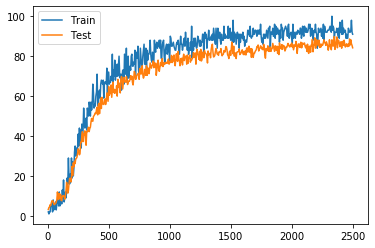

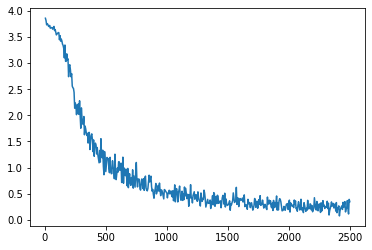

In [33]:
plt.plot(i_vals, train_acc)
plt.plot(i_vals, test_acc)
plt.legend(['Train', 'Test'])
plt.show()
plt.plot(i_vals, train_loss)
plt.show()